In [11]:
% when running localy
path_to_spm = '/home/remi/matlab/SPM/spm12/';
addpath(path_to_spm)

spm('defaults', 'FMRI');

Adapted from https://github.com/Remi-Gau/advanced_fMRI_course/blob/master/Practical%232/practical_2.m

Let's create a small helper function to help us plot the axis, legend...

This way we won't duplicate of this code everywhere.

Remember the [DRY principle](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself): **Don't Repeat Yourself!** 
If you are copy-pasting code, you are better off making a function out of it... In other words: copy-pasta leads to [spaghetti code](https://en.wikipedia.org/wiki/Spaghetti_code).

In [12]:
function set_axis(line_handles, plot_legend, x_max, temp_res)

    LINEWIDTH = 4;
    FONTSIZE = 12;

    % baseline
    plot([0 x_max * temp_res], [0 0], 'k');

    for i = 1:numel(line_handles)
        set(line_handles(i), 'linewidth', LINEWIDTH)
    end

    t = legend(plot_legend);
    set(t, 'fontsize', FONTSIZE);

    ax = axis;
    ax(2) = x_max * temp_res;
    axis(ax);

    x_tick = (0:5:x_max) * temp_res;
    set(gca, 'xtick', x_tick, ...
             'xticklabel',0:5:x_max, ...
             'fontsize', FONTSIZE)
    xlabel('time (s)')

end

### Define HRF

We first use the the `spm_get_bf` to get the "basis function" we will use to convolve the model of our neuronal response.

In this case we are going to create a typical hemodynamic response function (HRF) with a temporal and dispersion derivatives: also called the "informed basis set" (not the cutest name, but we were not consulted when it was coined).

We will show later how those derivatives can be used to model BOLD reponse that differ from the typical response.

In [13]:
temporal_resolution = 10; % in hertz
run_duration = 33; % in seconds
onset_vector = zeros(run_duration * temporal_resolution, 1);

In [14]:
xBF.name = 'hrf (with time and dispersion derivatives)';

% duration of each bin at which we we are creating the HRF
xBF.dt = 1 / temporal_resolution; 

% Length of the HRF in seconds
xBF.length = 33;
xBF.order = 1;

% Creates the informed basis set
xBF = spm_get_bf(xBF); 

canonical_HRF = xBF.bf(:,1);
temporal_derivative = xBF.bf(:,2);
dispersion_derivative = xBF.bf(:,3);

##### FYI

The code below will give you the shape of the HRF at a given temporal reosulution

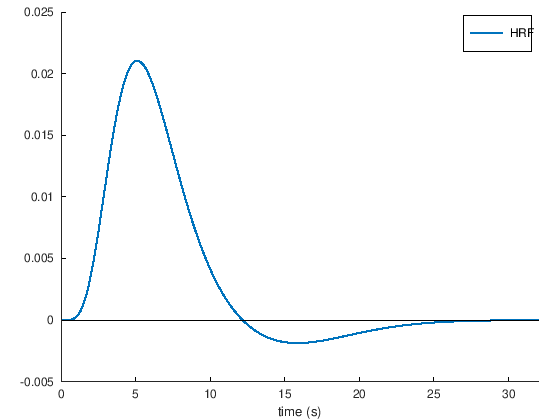

In [15]:
HRF = spm_hrf(1 / temporal_resolution);

hold on
h = plot(HRF);
set_axis(h, 'HRF', 32, temporal_resolution)

### Create impulse response

In [16]:
% We simulate a neural event that happened at the very beginning of the run
onset_vector(1) = 1;

% onset_vector(80) = 1;

### Convolve impulse response with HRF

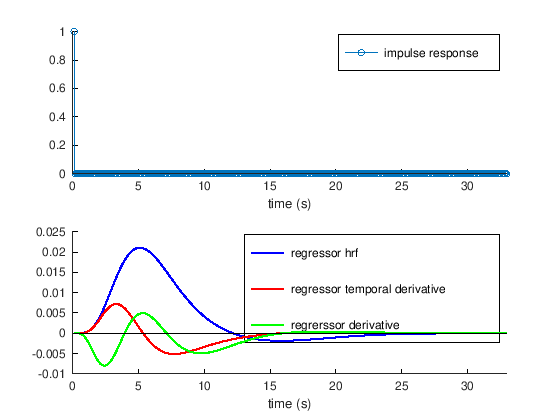

In [17]:
regressor_hrf = conv(canonical_HRF, onset_vector);
regressor_temp = conv(temporal_derivative, onset_vector);
regressor_disp = conv(dispersion_derivative, onset_vector);


subplot(211)
hold on

stem(onset_vector);

LEGEND={'impulse response'};
set_axis([], LEGEND, run_duration, temporal_resolution)


subplot(212)
hold on

h(1) = plot(regressor_hrf(1:length(onset_vector)), 'b');
h(2) = plot(regressor_temp(1:length(onset_vector)), 'r');
h(3) = plot(regressor_disp(1:length(onset_vector)), 'g');

LEGEND={'regressor hrf'; ...
        'regressor temporal derivative'; ...
        'regrerssor derivative'};
set_axis(h, LEGEND, run_duration, temporal_resolution)

### Design matrix

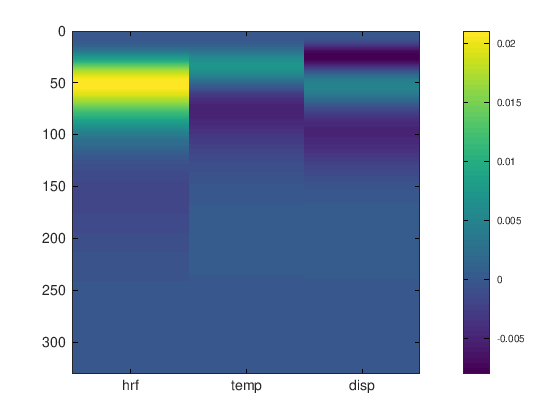

In [18]:
X = [regressor_hrf, regressor_temp, regressor_disp];

% h(1) = plot(regressor_hrf(1:length(onset_vector)), 'b');

imagesc(X(1:length(onset_vector),:))
colorbar
set(gca, 'xtick', [1 2 3] , ...
         'xticklabel', {'hrf', 'temp', 'disp'}, ...
         'fontsize', 14)

### Effects of HRF derivatives

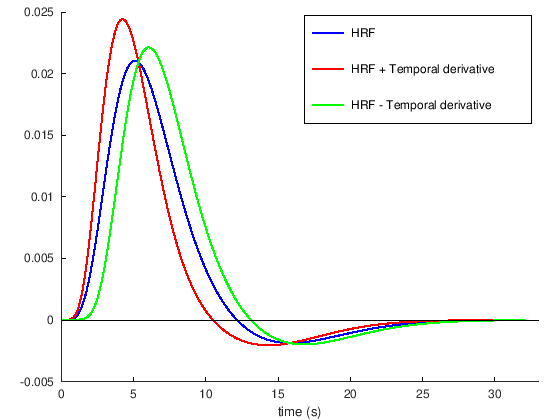

In [19]:
hold on

h(1) = plot(canonical_HRF, 'b');
h(2) = plot(canonical_HRF + temporal_derivative, 'r');
h(3) = plot(canonical_HRF - temporal_derivative, 'g');

LEGEND={'HRF'; ...
        'HRF + Temporal derivative'; ...
        'HRF - Temporal derivative'};
set_axis(h, LEGEND, run_duration, temporal_resolution)

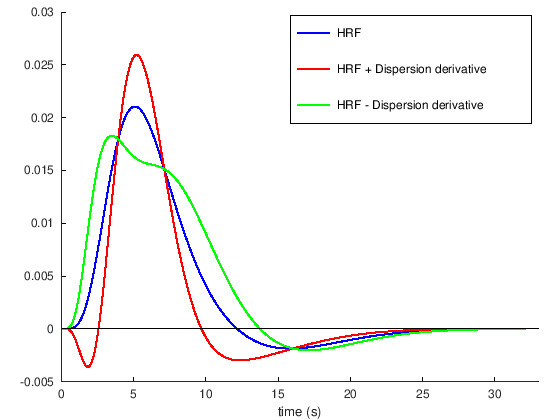

In [20]:
hold on 

h(1) = plot(canonical_HRF, 'b');
h(2) = plot(canonical_HRF + dispersion_derivative, 'r');
h(3) = plot(canonical_HRF - dispersion_derivative, 'g');

LEGEND={'HRF'; ...
        'HRF + Dispersion derivative'; ...
        'HRF - Dispersion derivative'};
set_axis(h, LEGEND, run_duration, temporal_resolution)